In [1]:
#classes = hp['classes']

import pandas as pd
#import xlrd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.impute import KNNImputer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
pd.DataFrame.iteritems=pd.DataFrame.items
tf.compat.v1.disable_v2_behavior()
# change the strings to ints
#input= pd.DataFrame(pd.read_csv("US Insurance Claims Data.xlsx", encoding='utf-16-le', encoding_errors='ignore'))


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_excel("US_Insurance_Claims_Data.xlsx")

# Step 1: Separate datetime columns
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
df_datetime = df[datetime_cols]

# Step 2: Exclude datetime columns for KNN imputation
df_knn = df.drop(columns=datetime_cols).copy()

# Step 3: Label encode categorical columns
label_encoders = {}
for col in df_knn.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    label_encoders[col] = le

# Step 4: Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)

# Step 5: Round integer columns
for col in df_knn.select_dtypes(include='int64').columns:
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)

# Step 6: Reverse label encoding
for col, le in label_encoders.items():
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)
    df_knn_imputed[col] = le.inverse_transform(df_knn_imputed[col])

# Step 7: Reattach datetime columns
df_cleaned = pd.concat([df_knn_imputed, df_datetime.reset_index(drop=True)], axis=1)

# Step 8: Final check
print("Missing values after KNN imputation:", df_cleaned.isnull().sum().sum())

# Optional: Save result
df_cleaned.to_csv("US_Insurance_KNN_Imputed.csv", index=False)
input=pd.read_csv("US_Insurance_KNN_Imputed.csv")
input=input.fillna(method='bfill').fillna(method='ffill')

Missing values after KNN imputation: 0


In [4]:
input.incident_location=input.incident_location.astype('category').cat.codes
input.policy_state=input.policy_state.astype('category').cat.codes
input.insured_education_level=input.insured_education_level.astype('category').cat.codes
input.insured_sex=input.insured_sex.astype('category').cat.codes
input.insured_hobbies=input.insured_hobbies.astype('category').cat.codes
input.insured_relationship=input.insured_relationship.astype('category').cat.codes
input.incident_type=input.incident_type.astype('category').cat.codes
input.collision_type=input.collision_type.astype('category').cat.codes
input.incident_severity=input.incident_severity.astype('category').cat.codes
input.authorities_contacted=input.authorities_contacted.astype('category').cat.codes
input.incident_state=input.incident_state.astype('category').cat.codes
input.incident_city=input.incident_city.astype('category').cat.codes
input.insured_occupation=input.insured_occupation.astype('category').cat.codes
input.property_damage=input.property_damage.astype('category').cat.codes
input.police_report_available=input.police_report_available.astype('category').cat.codes
input.auto_make=input.auto_make.astype('category').cat.codes
input.auto_model=input.auto_model.astype('category').cat.codes
#input['fraud_reported']=input['fraud_reported'].fillna(method='ffill').fillna(method='bfill')
input.fraud_reported=input.fraud_reported.astype('category').cat.codes
input.incident_date=input.incident_date.astype('category').cat.codes
input.policy_bind_date=input.incident_date.astype('category').cat.codes
input['policy_csl'] = input['policy_csl'].apply(lambda x: eval(x))

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.preprocessing.sequence import pad_sequences

#trainX_padded = pad_sequences(trainX, padding='post', truncating='post')
#testX_padded = pad_sequences(testX, padding='post', truncating='post')
#trainY_padded = pad_sequences(trainY, padding='post', truncating='post')
#testY_padded = pad_sequences(testY, padding='post', truncating='post')



grouped = input.groupby('months_as_customer')

# Extract sequences and labels
sequences = grouped.apply(lambda X: X[['months_as_customer', 'age', 'policy_number', 'policy_bind_date' , 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year']].values.tolist())
labels = grouped['fraud_reported'].first().values
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad to same length (post-padding with zeros)
X = pad_sequences(sequences.tolist(), padding='post', dtype='float32')
y = np.array(labels)
# Flatten time dimension to create 2D array for VIF calculation
# Shape: (samples * timesteps, features)
X_2d_for_vif = X.reshape(-1, X.shape[2])

def calculate_vif_3d(X_2d, thresh=5.0):
    print("Calculating VIF for each feature (collapsed over timesteps)...")
    variables = list(range(X_2d.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_2d[:, variables], ix) for ix in range(len(variables))]
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print(f"Dropping feature at index {variables[maxloc]} with VIF={max_vif:.2f}")
            variables.pop(maxloc)
            dropped = True
    return variables

# Calculate VIF and get list of features to keep
features_to_keep = calculate_vif_3d(X_2d_for_vif, thresh=10.0)

print(f"Selected {len(features_to_keep)} features out of {X.shape[2]} based on VIF")

# Filter original X on feature dimension (3rd dimension)
X_filtered = X[:, :, features_to_keep]

# Now flatten for SMOTE and undersampling (samples, timesteps*features_kept)
X_flat = X_filtered.reshape(X_filtered.shape[0], -1)

smote = SMOTE(random_state=42)
#rus = RandomUnderSampler(random_state=1000)

# Apply SMOTE then undersampling
X_resampled, y_resampled = smote.fit_resample(X_flat, y)
#X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

timesteps = X_filtered.shape[1]
features_kept = X_filtered.shape[2]

X_resampled = X_resampled.reshape(-1, timesteps, features_kept)

#print(f"Original shape: {X.shape}")
#print(f"Filtered shape (after VIF): {X_filtered.shape}")
#print(f"Resampled shape: {X_resampled_3d.shape}")
#print(f"Original class distribution: {np.bincount(y)}")
#print(f"Resampled class distribution: {np.bincount(y_resampled)}")

# X_resampled_3d, y_resampled are now ready for your sequential model


Calculating VIF for each feature (collapsed over timesteps)...
Dropping feature at index 3 with VIF=1576338686514.00
Dropping feature at index 31 with VIF=6543.02
Dropping feature at index 37 with VIF=226.42
Dropping feature at index 1 with VIF=107.59
Dropping feature at index 9 with VIF=38.70
Dropping feature at index 5 with VIF=27.07
Dropping feature at index 7 with VIF=22.99
Dropping feature at index 34 with VIF=18.26
Dropping feature at index 26 with VIF=13.62
Selected 29 features out of 38 based on VIF



📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 04:56:59.914334: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_92/lstm_cell/kernel/Assign' id:166119 op device:{requested: '', assigned: ''} def:{{{node lstm_92/lstm_cell/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_92/lstm_cell/kernel, lstm_92/lstm_cell/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 04:57:18.921800: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_154/mul' id:166625 op device:{requ

🔍 Calculating SHAP values for fold 1 of 'Convex Only'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 05:09:18.722170: W tensorflow/c/c_api.cc:304] Operation '{name:'training_278/Adam/lstm_93/lstm_cell/kernel/m/Assign' id:168899 op device:{requested: '', assigned: ''} def:{{{node training_278/Adam/lstm_93/lstm_cell/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_278/Adam/lstm_93/lstm_cell/kernel/m, training_278/Adam/lstm_93/lstm_cell/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 05:09:37.665273: W tensorflow/c/


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 05:20:56.091983: W tensorflow/c/c_api.cc:304] Operation '{name:'total_140/Assign' id:169328 op device:{requested: '', assigned: ''} def:{{{node total_140/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_140, total_140/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 05:21:15.044067: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_157/mul' id:169585 op device:{requested: '', assigned: ''} def:{{{node loss_157/mul}} = Mul[T=DT_FLOAT,


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 05:41:36.481009: W tensorflow/c/c_api.cc:304] Operation '{name:'total_141/Assign' id:170589 op device:{requested: '', assigned: ''} def:{{{node total_141/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_141, total_141/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 05:41:56.188543: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_158/mul' id:170846 op device:{requested: '', assigned: ''} def:{{{node loss_158/mul}} = Mul[T=DT_FLOAT,


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 05:54:05.312119: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_96/lstm_cell/recurrent_kernel/Assign' id:171621 op device:{requested: '', assigned: ''} def:{{{node lstm_96/lstm_cell/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_96/lstm_cell/recurrent_kernel, lstm_96/lstm_cell/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 05:54:24.644332: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_159


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 06:06:29.682127: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_430/Assign' id:173080 op device:{requested: '', assigned: ''} def:{{{node true_positives_430/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_430, true_positives_430/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 06:06:48.956255: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_160/mul' id:173368 op device:{requested: '', assigned: ''} def:{{{n


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 06:19:14.284012: W tensorflow/c/c_api.cc:304] Operation '{name:'training_288/Adam/lstm_98/lstm_cell/kernel/m/Assign' id:175204 op device:{requested: '', assigned: ''} def:{{{node training_288/Adam/lstm_98/lstm_cell/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_288/Adam/lstm_98/lstm_cell/kernel/m, training_288/Adam/lstm_98/lstm_cell/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 06:19:33.647437: W tensorflow/c/


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 06:31:21.038782: W tensorflow/c/c_api.cc:304] Operation '{name:'training_290/Adam/iter/Assign' id:176443 op device:{requested: '', assigned: ''} def:{{{node training_290/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_290/Adam/iter, training_290/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 06:31:40.549839: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_162/mul' id:175890 op device:{requested: '', assign


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 06:42:24.223991: W tensorflow/c/c_api.cc:304] Operation '{name:'training_292/Adam/lstm_100/lstm_cell/kernel/v/Assign' id:177755 op device:{requested: '', assigned: ''} def:{{{node training_292/Adam/lstm_100/lstm_cell/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_292/Adam/lstm_100/lstm_cell/kernel/v, training_292/Adam/lstm_100/lstm_cell/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 06:42:36.814858: W tensorflo


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-07-15 06:52:07.182749: W tensorflow/c/c_api.cc:304] Operation '{name:'training_294/Adam/lstm_101/lstm_cell/bias/v/Assign' id:179028 op device:{requested: '', assigned: ''} def:{{{node training_294/Adam/lstm_101/lstm_cell/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_294/Adam/lstm_101/lstm_cell/bias/v, training_294/Adam/lstm_101/lstm_cell/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 06:52:20.649539: W tensorflow/c/c_ap


📊 Average metrics for schedule 'Convex Only': {'loss': 0.6592289749429197, 'accuracy': 0.60107595, 'precision': 0.6159996, 'recall': 0.5572175, 'f1': 0.5793807311731294, 'auc': 0.6484169092160379}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 07:01:45.799005: W tensorflow/c/c_api.cc:304] Operation '{name:'training_296/Adam/dense_102/kernel/v/Assign' id:180294 op device:{requested: '', assigned: ''} def:{{{node training_296/Adam/dense_102/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_296/Adam/dense_102/kernel/v, training_296/Adam/dense_102/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 07:01:58.797417: W tensorflow/c/c_api.cc:304] Operation '{name:'


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 07:02:55.349503: W tensorflow/c/c_api.cc:304] Operation '{name:'count_149/Assign' id:180459 op device:{requested: '', assigned: ''} def:{{{node count_149/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_149, count_149/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:03:08.015596: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_166/mul' id:180711 op device:{requested: '', assigned: ''} def:{{{node loss_166/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_166/mul/x, loss_166/dense_102_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 07:06:49.957695: W tensorflow/c/c_api.cc:304] Operation '{name:'total_150/Assign' id:181395 op device:{requested: '', assigned: ''} def:{{{node total_150/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_150, total_150/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:07:02.862486: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_167/mul' id:181652 op device:{requested: '', assigned: ''} def:{{{node loss_167/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_167/mul/x, loss_167/dense_102_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

🔍 Calculating SHAP values for fold 1 of 'Multistage_1'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 07:12:01.785950: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_103/lstm_cell/bias/Assign' id:182777 op device:{requested: '', assigned: ''} def:{{{node lstm_103/lstm_cell/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_103/lstm_cell/bias, lstm_103/lstm_cell/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 07:12:14.619187: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_169/mul' id:183254 op device:{requested: '', a


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 07:13:09.044625: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_456/Assign' id:183994 op device:{requested: '', assigned: ''} def:{{{node true_positives_456/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_456, true_positives_456/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:13:22.127352: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_170/mul' id:184292 op device:{requested: '', assigned: ''} def:{{{node loss_170/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_170/mul/x, loss_170/dense_103_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 07:17:08.449362: W tensorflow/c/c_api.cc:304] Operation '{name:'true_negatives_153/Assign' id:184960 op device:{requested: '', assigned: ''} def:{{{node true_negatives_153/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_153, true_negatives_153/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:17:22.001171: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_171/mul' id:185233 op device:{requested: '', assigned: ''} def:{{{node loss_171/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_171/mul/x, loss_171/dense_103_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


📂 Fold 3/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 07:22:17.192781: W tensorflow/c/c_api.cc:304] Operation '{name:'training_308/Adam/dense_104/bias/m/Assign' id:186994 op device:{requested: '', assigned: ''} def:{{{node training_308/Adam/dense_104/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_308/Adam/dense_104/bias/m, training_308/Adam/dense_104/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 07:22:30.459381: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_172


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 07:23:28.333458: W tensorflow/c/c_api.cc:304] Operation '{name:'false_negatives_310/Assign' id:187152 op device:{requested: '', assigned: ''} def:{{{node false_negatives_310/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_310, false_negatives_310/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:23:41.468212: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_173/mul' id:187435 op device:{requested: '', assigned: ''} def:{{{node loss_173/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_173/mul/x, loss_173/dense_104_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 07:27:26.064573: W tensorflow/c/c_api.cc:304] Operation '{name:'false_negatives_312/Assign' id:188093 op device:{requested: '', assigned: ''} def:{{{node false_negatives_312/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_312, false_negatives_312/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:27:39.328079: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_174/mul' id:188376 op device:{requested: '', assigned: ''} def:{{{node loss_174/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_174/mul/x, loss_174/dense_104_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node


📂 Fold 4/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 07:32:29.149531: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_105/lstm_cell/kernel/Assign' id:189034 op device:{requested: '', assigned: ''} def:{{{node lstm_105/lstm_cell/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_105/lstm_cell/kernel, lstm_105/lstm_cell/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 07:32:42.472904: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_175/mul' id:189540 op device:{


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 07:33:37.178438: W tensorflow/c/c_api.cc:304] Operation '{name:'true_negatives_158/Assign' id:190305 op device:{requested: '', assigned: ''} def:{{{node true_negatives_158/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_158, true_negatives_158/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:33:50.530073: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_176/mul' id:190578 op device:{requested: '', assigned: ''} def:{{{node loss_176/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_176/mul/x, loss_176/dense_105_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 07:37:33.497674: W tensorflow/c/c_api.cc:304] Operation '{name:'count_159/Assign' id:191267 op device:{requested: '', assigned: ''} def:{{{node count_159/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_159, count_159/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:37:46.957791: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_177/mul' id:191519 op device:{requested: '', assigned: ''} def:{{{node loss_177/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_177/mul/x, loss_177/dense_105_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses


📂 Fold 5/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 07:42:34.810203: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_106/lstm_cell/recurrent_kernel/Assign' id:192197 op device:{requested: '', assigned: ''} def:{{{node lstm_106/lstm_cell/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_106/lstm_cell/recurrent_kernel, lstm_106/lstm_cell/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 07:42:48.158247: W tensorflow/c/c_api.cc:304] Operation '{name:'loss


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 07:43:43.509205: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_322/Assign' id:193428 op device:{requested: '', assigned: ''} def:{{{node false_positives_322/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_322, false_positives_322/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:43:56.905859: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_179/mul' id:193721 op device:{requested: '', assigned: ''} def:{{{node loss_179/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_179/mul/x, loss_179/dense_106_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 07:47:41.015482: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_324/Assign' id:194369 op device:{requested: '', assigned: ''} def:{{{node false_positives_324/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_324, false_positives_324/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:47:54.603923: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_180/mul' id:194662 op device:{requested: '', assigned: ''} def:{{{node loss_180/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_180/mul/x, loss_180/dense_106_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node


📂 Fold 6/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 07:52:39.226282: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_107/bias/Assign' id:195518 op device:{requested: '', assigned: ''} def:{{{node dense_107/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_107/bias, dense_107/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 07:52:52.836272: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_181/mul' id:195826 op device:{requested: '', assigned: ''} def:{{{node loss_181/mul


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 07:53:48.571456: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_494/Assign' id:196586 op device:{requested: '', assigned: ''} def:{{{node true_positives_494/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_494, true_positives_494/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:54:02.019151: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_182/mul' id:196864 op device:{requested: '', assigned: ''} def:{{{node loss_182/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_182/mul/x, loss_182/dense_107_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 07:57:50.705218: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_496/Assign' id:197517 op device:{requested: '', assigned: ''} def:{{{node true_positives_496/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_496, true_positives_496/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 07:58:04.325490: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_183/mul' id:197805 op device:{requested: '', assigned: ''} def:{{{node loss_183/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_183/mul/x, loss_183/dense_107_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


📂 Fold 7/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 08:02:45.481336: W tensorflow/c/c_api.cc:304] Operation '{name:'training_332/Adam/dense_108/kernel/m/Assign' id:199561 op device:{requested: '', assigned: ''} def:{{{node training_332/Adam/dense_108/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_332/Adam/dense_108/kernel/m, training_332/Adam/dense_108/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 08:02:59.056750: W tensorflow/c/c_api.cc:304] Operation '{name:'


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 08:03:54.559993: W tensorflow/c/c_api.cc:304] Operation '{name:'count_167/Assign' id:199755 op device:{requested: '', assigned: ''} def:{{{node count_167/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_167, count_167/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 08:04:08.137583: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_185/mul' id:200007 op device:{requested: '', assigned: ''} def:{{{node loss_185/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_185/mul/x, loss_185/dense_108_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 08:07:51.528922: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_337/Assign' id:200680 op device:{requested: '', assigned: ''} def:{{{node false_positives_337/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_337, false_positives_337/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 08:08:05.242602: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_186/mul' id:200948 op device:{requested: '', assigned: ''} def:{{{node loss_186/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_186/mul/x, loss_186/dense_108_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node


📂 Fold 8/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 08:12:48.513538: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_109/bias/Assign' id:201804 op device:{requested: '', assigned: ''} def:{{{node dense_109/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_109/bias, dense_109/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 08:13:02.269578: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_187/mul' id:202112 op device:{requested: '', assigned: ''} def:{{{node loss_187/mul


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 08:13:58.615869: W tensorflow/c/c_api.cc:304] Operation '{name:'true_negatives_170/Assign' id:202877 op device:{requested: '', assigned: ''} def:{{{node true_negatives_170/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_170, true_negatives_170/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 08:14:12.319850: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_188/mul' id:203150 op device:{requested: '', assigned: ''} def:{{{node loss_188/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_188/mul/x, loss_188/dense_109_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 08:17:59.428708: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_514/Assign' id:203803 op device:{requested: '', assigned: ''} def:{{{node true_positives_514/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_514, true_positives_514/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 08:18:13.393063: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_189/mul' id:204091 op device:{requested: '', assigned: ''} def:{{{node loss_189/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_189/mul/x, loss_189/dense_109_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


📂 Fold 9/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 08:23:01.787383: W tensorflow/c/c_api.cc:304] Operation '{name:'training_344/Adam/lstm_110/lstm_cell/recurrent_kernel/m/Assign' id:205837 op device:{requested: '', assigned: ''} def:{{{node training_344/Adam/lstm_110/lstm_cell/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_344/Adam/lstm_110/lstm_cell/recurrent_kernel/m, training_344/Adam/lstm_110/lstm_cell/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 08:24:10.001225: W tensorflow/c/c_api.cc:304] Operation '{name:'count_173/Assign' id:206041 op device:{requested: '', assigned: ''} def:{{{node count_173/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_173, count_173/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 08:24:23.914143: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_191/mul' id:206293 op device:{requested: '', assigned: ''} def:{{{node loss_191/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_191/mul/x, loss_191/dense_110_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 08:28:10.947032: W tensorflow/c/c_api.cc:304] Operation '{name:'true_negatives_174/Assign' id:206961 op device:{requested: '', assigned: ''} def:{{{node true_negatives_174/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_174, true_negatives_174/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 08:28:24.888199: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_192/mul' id:207234 op device:{requested: '', assigned: ''} def:{{{node loss_192/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_192/mul/x, loss_192/dense_110_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


📂 Fold 10/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-07-15 08:33:07.807567: W tensorflow/c/c_api.cc:304] Operation '{name:'training_350/Adam/lstm_111/lstm_cell/kernel/m/Assign' id:208973 op device:{requested: '', assigned: ''} def:{{{node training_350/Adam/lstm_111/lstm_cell/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_350/Adam/lstm_111/lstm_cell/kernel/m, training_350/Adam/lstm_111/lstm_cell/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 08:33:22.328613: W tensorflo


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-07-15 08:34:20.414464: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_352/Assign' id:209143 op device:{requested: '', assigned: ''} def:{{{node false_positives_352/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_352, false_positives_352/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 08:34:34.457959: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_194/mul' id:209436 op device:{requested: '', assigned: ''} def:{{{node loss_194/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_194/mul/x, loss_194/dense_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 08:38:23.196736: W tensorflow/c/c_api.cc:304] Operation '{name:'false_negatives_354/Assign' id:210094 op device:{requested: '', assigned: ''} def:{{{node false_negatives_354/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_354, false_negatives_354/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-15 08:38:37.550699: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_195/mul' id:210377 op device:{requested: '', assigned: ''} def:{{{node loss_195/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_195/mul/x, loss_195/dense_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node


📊 Average metrics for schedule 'Multistage_1': {'loss': 0.042769497973443586, 'accuracy': 0.6276899, 'precision': 0.62700623, 'recall': 0.66018754, 'f1': 0.6346389362983992, 'auc': 0.6828163825328228}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 08:43:27.093752: W tensorflow/c/c_api.cc:304] Operation '{name:'count_178/Assign' id:211289 op device:{requested: '', assigned: ''} def:{{{node count_178/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_178, count_178/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 08:43:41.258711: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_196/mul' id:211541 op device:{requested: '', assigned: ''} def:{{{node loss_196/mul}} = Mul[T=DT_FLOAT,

🔍 Calculating SHAP values for fold 1 of 'Nonconvex Only'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 08:53:16.325759: W tensorflow/c/c_api.cc:304] Operation '{name:'true_negatives_179/Assign' id:212967 op device:{requested: '', assigned: ''} def:{{{node true_negatives_179/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_179, true_negatives_179/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 08:53:30.771342: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_198/mul' id:213240 op device:{requested: '', assigned: ''} def:{{{n


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 09:03:10.969318: W tensorflow/c/c_api.cc:304] Operation '{name:'training_360/Adam/beta_2/Assign' id:215064 op device:{requested: '', assigned: ''} def:{{{node training_360/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_360/Adam/beta_2, training_360/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 09:03:25.316910: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_199/mul' id:214501 op device:{reque


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 09:12:57.952465: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_363/Assign' id:215494 op device:{requested: '', assigned: ''} def:{{{node false_positives_363/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_363, false_positives_363/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 09:13:12.592769: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_200/mul' id:215762 op device:{requested: '', assigned: ''} def:


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 09:23:15.252648: W tensorflow/c/c_api.cc:304] Operation '{name:'training_364/Adam/dense_116/kernel/v/Assign' id:217644 op device:{requested: '', assigned: ''} def:{{{node training_364/Adam/dense_116/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_364/Adam/dense_116/kernel/v, training_364/Adam/dense_116/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 09:23:30.006264: W tensorflow/c/c_api.cc:304] Operation '{name:'


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 09:33:16.144674: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_117/bias/Assign' id:217976 op device:{requested: '', assigned: ''} def:{{{node dense_117/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_117/bias, dense_117/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 09:33:30.920372: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_202/mul' id:218284 op device:{requested: '', assigned: ''} def:{{{node loss_202/mul


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 09:43:01.744585: W tensorflow/c/c_api.cc:304] Operation '{name:'training_368/Adam/lstm_118/lstm_cell/kernel/m/Assign' id:220120 op device:{requested: '', assigned: ''} def:{{{node training_368/Adam/lstm_118/lstm_cell/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_368/Adam/lstm_118/lstm_cell/kernel/m, training_368/Adam/lstm_118/lstm_cell/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 09:43:16.613109: W tensorflo


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 09:52:52.334259: W tensorflow/c/c_api.cc:304] Operation '{name:'false_negatives_371/Assign' id:220543 op device:{requested: '', assigned: ''} def:{{{node false_negatives_371/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_371, false_negatives_371/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 09:53:07.062835: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_204/mul' id:220806 op device:{requested: '', assigned: ''} def:


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 10:45:13.281989: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_560/Assign' id:221789 op device:{requested: '', assigned: ''} def:{{{node true_positives_560/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_560, true_positives_560/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 10:46:28.035344: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_205/mul' id:222067 op device:{requested: '', assigned: ''} def:{{{n


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-07-15 11:02:09.388067: W tensorflow/c/c_api.cc:304] Operation '{name:'training_374/Adam/iter/Assign' id:223881 op device:{requested: '', assigned: ''} def:{{{node training_374/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_374/Adam/iter, training_374/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 11:02:31.311494: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_206/mul' id:223328 op device:{requested: '', assign


📊 Average metrics for schedule 'Nonconvex Only': {'loss': 0.16341790886619423, 'accuracy': 0.60113925, 'precision': 0.60126925, 'recall': 0.64742726, 'f1': 0.6133514883914246, 'auc': 0.6562014005661535}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 11:14:15.756599: W tensorflow/c/c_api.cc:304] Operation '{name:'training_376/Adam/dense_122/bias/v/Assign' id:225215 op device:{requested: '', assigned: ''} def:{{{node training_376/Adam/dense_122/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_376/Adam/dense_122/bias/v, training_376/Adam/dense_122/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 11:14:38.211112: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_207

🔍 Calculating SHAP values for fold 1 of 'Hybrid'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 11:26:53.129723: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_123/lstm_cell/recurrent_kernel/Assign' id:225802 op device:{requested: '', assigned: ''} def:{{{node lstm_123/lstm_cell/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_123/lstm_cell/recurrent_kernel, lstm_123/lstm_cell/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 11:27:15.830629: W tensorflow/c/c_api.cc:304] Operation '{name:'loss


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 11:39:12.230938: W tensorflow/c/c_api.cc:304] Operation '{name:'false_negatives_381/Assign' id:227286 op device:{requested: '', assigned: ''} def:{{{node false_negatives_381/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_381, false_negatives_381/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 11:39:35.097373: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_210/mul' id:227549 op device:{requested: '', assigned: ''} def:


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 11:51:39.941352: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_125/lstm_cell/kernel/Assign' id:228304 op device:{requested: '', assigned: ''} def:{{{node lstm_125/lstm_cell/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_125/lstm_cell/kernel, lstm_125/lstm_cell/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 11:52:04.098611: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_211/mul' id:228810 op device:{


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 12:04:25.815888: W tensorflow/c/c_api.cc:304] Operation '{name:'training_384/Adam/lstm_126/lstm_cell/kernel/m/Assign' id:230646 op device:{requested: '', assigned: ''} def:{{{node training_384/Adam/lstm_126/lstm_cell/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_384/Adam/lstm_126/lstm_cell/kernel/m, training_384/Adam/lstm_126/lstm_cell/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 12:04:49.610817: W tensorflo


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 12:17:11.324058: W tensorflow/c/c_api.cc:304] Operation '{name:'training_386/Adam/beta_2/Assign' id:231895 op device:{requested: '', assigned: ''} def:{{{node training_386/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_386/Adam/beta_2, training_386/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 12:17:35.781123: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_213/mul' id:231332 op device:{reque


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 12:30:10.584648: W tensorflow/c/c_api.cc:304] Operation '{name:'training_388/Adam/beta_1/Assign' id:233151 op device:{requested: '', assigned: ''} def:{{{node training_388/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_388/Adam/beta_1, training_388/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 12:30:34.938393: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_214/mul' id:232593 op device:{reque


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 12:42:49.011335: W tensorflow/c/c_api.cc:304] Operation '{name:'training_390/Adam/lstm_129/lstm_cell/recurrent_kernel/m/Assign' id:234436 op device:{requested: '', assigned: ''} def:{{{node training_390/Adam/lstm_129/lstm_cell/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_390/Adam/lstm_129/lstm_cell/recurrent_kernel/m, training_390/Adam/lstm_129/lstm_cell/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 12:55:37.635258: W tensorflow/c/c_api.cc:304] Operation '{name:'training_392/Adam/iter/Assign' id:235668 op device:{requested: '', assigned: ''} def:{{{node training_392/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_392/Adam/iter, training_392/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 12:56:02.426659: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_216/mul' id:235115 op device:{requested: '', assign


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-07-15 13:06:42.434203: W tensorflow/c/c_api.cc:304] Operation '{name:'training_394/Adam/iter/Assign' id:236929 op device:{requested: '', assigned: ''} def:{{{node training_394/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_394/Adam/iter, training_394/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-15 13:06:58.424681: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_217/mul' id:236376 op device:{requested: '', assign


📊 Average metrics for schedule 'Hybrid': {'loss': 0.04092130691850487, 'accuracy': 0.6073892, 'precision': 0.61036885, 'recall': 0.6381789, 'f1': 0.6155044981475166, 'auc': 0.667673546809417}
✅ Metrics exported to 'cross_validation_results_2.csv'


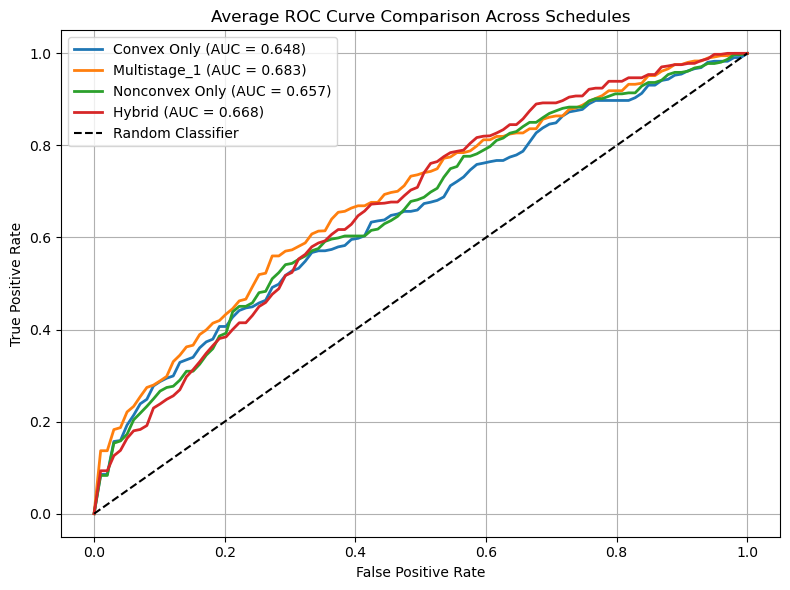

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import pandas as pd

shap_feature_importance = {}


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.utils import class_weight




import tensorflow as tf
import tensorflow.keras.backend as K

class NoisyLossWrapper(tf.keras.losses.Loss):
    def __init__(self, base_loss_fn, noise_scale=0.5, name='noisy_loss'):
        super(NoisyLossWrapper, self).__init__(name=name)
        self.base_loss_fn = base_loss_fn
        self.noise_scale = noise_scale

    def call(self, y_true, y_pred):
        base_loss = self.base_loss_fn(y_true, y_pred)
        noise = tf.random.normal(shape=tf.shape(base_loss), mean=0.3, stddev=self.noise_scale) # make noise 0
        return base_loss + noise






def model_builder():
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=(X_filtered.shape[1], X_filtered.shape[2])),
        tf.keras.layers.LSTM(128),
        #tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model



convex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False, alpha=0.25, gamma=0.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#convex_focal_loss = NoisyLossWrapper(convex_focal_loss_fn, noise_scale=0.5)
convex_focal_loss=convex_focal_loss_fn
convex_focal_loss.__name__ = "convex_focal_loss"

nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False, alpha=0.25, gamma=2.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#nonconvex_focal_loss = NoisyLossWrapper(nonconvex_focal_loss_fn, noise_scale=0.5)
nonconvex_focal_loss = nonconvex_focal_loss_fn 
nonconvex_focal_loss.__name__ = "nonconvex_focal_loss"


hybrid_nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False, alpha=0.25, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#hybrid_nonconvex_focal_loss = NoisyLossWrapper(hybrid_nonconvex_focal_loss_fn, noise_scale=0.5)
hybrid_nonconvex_focal_loss = hybrid_nonconvex_focal_loss_fn 
hybrid_nonconvex_focal_loss.__name__ = "hybrid_nonconvex_focal_loss"



training_schedule_convex = [
    {"loss_fn": convex_focal_loss, "epochs": 100},
]

training_schedule_multistage_1 = [
    {"loss_fn": convex_focal_loss, "epochs": 10},
     {"loss_fn": nonconvex_focal_loss, "epochs":40},
      {"loss_fn": hybrid_nonconvex_focal_loss, "epochs":50},
]

training_schedule_multistage_2 = [
    {"loss_fn": convex_focal_loss, "epochs":10},
    {"loss_fn": nonconvex_focal_loss, "epochs":90},
]


hybrid_training_schedule_nonconvex = [
    {"loss_fn": hybrid_nonconvex_focal_loss, "epochs": 100},
]

training_schedule_nonconvex = [
    {"loss_fn": nonconvex_focal_loss, "epochs": 100},
]


def cross_validate(schedule, schedule_name, X_data, y_data, k_folds=10):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    metrics_list = []
    roc_data = []

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data)):
        print(f"\n📂 Fold {fold + 1}/{k_folds}")

        X_train_fold, X_val_fold = X_data[train_index], X_data[val_index]
        y_train_fold, y_val_fold = y_data[train_index], y_data[val_index]

        result = train_with_schedule_fold(schedule, schedule_name, X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold)
        metrics_list.append(result)
        roc_data.append((result["fpr"], result["tpr"]))

    avg_metrics = {
        "loss": np.mean([m["loss"] for m in metrics_list]),
        "accuracy": np.mean([m["accuracy"] for m in metrics_list]),
        "precision": np.mean([m["precision"] for m in metrics_list]),
        "recall": np.mean([m["recall"] for m in metrics_list]),
        "f1": np.mean([m["f1"] for m in metrics_list]),
        "auc": np.mean([m["auc"] for m in metrics_list]),
    }

    print(f"\n📊 Average metrics for schedule '{schedule_name}': {avg_metrics}")
    return avg_metrics, roc_data

def train_with_schedule_fold(schedule, schedule_name, trainX, trainY, testX, testY, fold_index):
    model = model_builder()

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
    current_epoch = 0

    for i, stage in enumerate(schedule):
        loss_fn = stage["loss_fn"]
        epochs = stage["epochs"]
        print(f"\n➡️ Stage {i + 1} | Epochs: {epochs} | Loss: {loss_fn.__name__}")

        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        model.fit(
            trainX, trainY,
            initial_epoch=current_epoch,
            epochs=current_epoch + epochs,
            batch_size=1,
            validation_data=(testX, testY),
            verbose=0
        )
        current_epoch += epochs

    eval_results = model.evaluate(testX, testY, verbose=0)
    y_pred_prob = model.predict(testX, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    f1 = f1_score(testY, y_pred)
    auc_score = roc_auc_score(testY, y_pred_prob)
    fpr, tpr, _ = roc_curve(testY, y_pred_prob)

    # SHAP values for fold 1 only
    if fold_index == 0:
        print(f"🔍 Calculating SHAP values for fold 1 of '{schedule_name}'")
        background = trainX[:100].astype(np.float32)
        test_sample = testX[:100].astype(np.float32)

        # Recompile without metrics for SHAP
        model.compile(optimizer=optimizer, loss=loss_fn)

        explainer = shap.GradientExplainer(model, background)
        shap_values = explainer.shap_values(test_sample)[0]

        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        feature_names = getattr(testX, "columns", [f"Feature {i}" for i in range(testX.shape[1])])
        shap_feature_importance[schedule_name] = dict(zip(feature_names, mean_abs_shap))

    return {
        "loss": eval_results[0],
        "accuracy": eval_results[1],
        "precision": eval_results[2],
        "recall": eval_results[3],
        "auc": auc_score,
        "f1": f1,
        "fpr": fpr,
        "tpr": tpr
    }

def average_roc_curves(roc_data, num_points=100):
    mean_fpr = np.linspace(0, 1, num_points)
    tprs = []

    for fpr, tpr in roc_data:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc

# 🧪 Run experiments and collect metrics
results_cv = {}
roc_data_schedules = {}


results_cv["Convex Only"], roc_data_schedules["Convex Only"] = cross_validate(training_schedule_convex, "Convex Only", X_resampled, y_resampled)
results_cv["Multistage_1"], roc_data_schedules["Multistage_1"] = cross_validate(training_schedule_multistage_1, "Multistage_1", X_resampled, y_resampled)
results_cv["Nonconvex Only"], roc_data_schedules["Nonconvex Only"] = cross_validate(training_schedule_nonconvex, "Nonconvex Only", X_resampled, y_resampled)
results_cv["Hybrid"], roc_data_schedules["Hybrid"] = cross_validate(hybrid_training_schedule_nonconvex, "Hybrid", X_resampled, y_resampled)
#results_cv["Multistage_2"], roc_data_schedules["Multistage_2"] = cross_validate(training_schedule_multistage_2, "Multistage_2", X_resampled, y_resampled)


# 📤 Export metrics to CSV
results_df = pd.DataFrame.from_dict(results_cv, orient='index')
results_df.to_csv("cross_validation_results_2.csv", index_label="Schedule")
print("✅ Metrics exported to 'cross_validation_results_2.csv'")

# 📊 Plot average ROC curves
plt.figure(figsize=(8, 6))
for name, data in roc_data_schedules.items():
    fpr, tpr, auc_val = average_roc_curves(data)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("Average ROC Curve Comparison Across Schedules")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 📊 SHAP Comparison Bar Plot
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)
shap_df["mean"] = shap_df.mean(axis=1)
shap_df
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")

shap_df = shap_df.sort_values("mean", ascending=True)
shap_df.drop("mean", axis=1, inplace=True)


In [12]:
# 📊 SHAP Comparison Bar Plot
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)
shap_df["mean"] = shap_df.mean(axis=1)
shap_df
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")

shap_df = shap_df.sort_values("mean", ascending=True)
shap_df.drop("mean", axis=1, inplace=True)


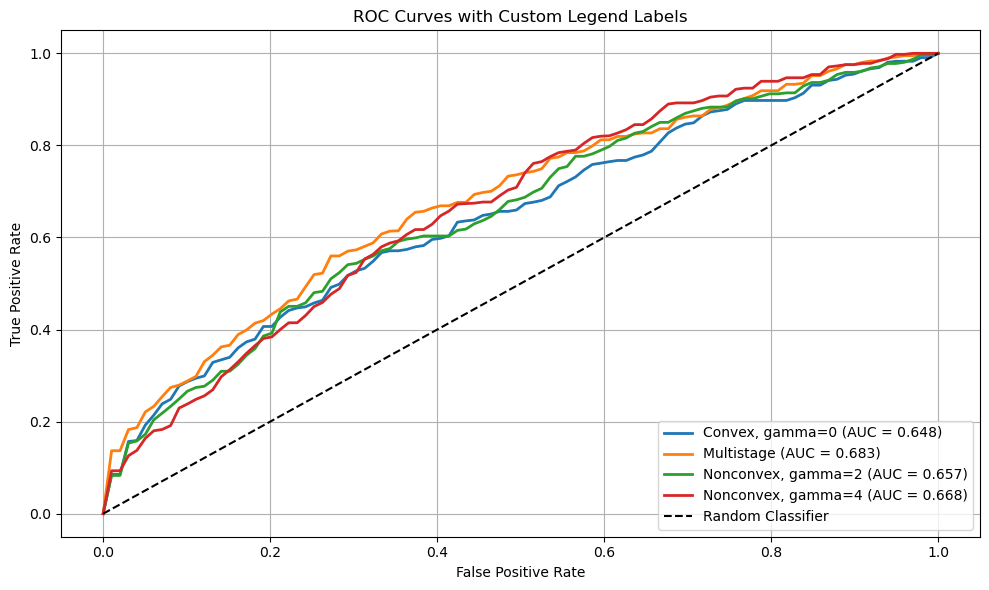

In [26]:
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]
legend_labels = {
    "Convex Only": "Convex, gamma=0",
    "Multistage_1": "Multistage",
    "Nonconvex Only": "Nonconvex, gamma=2",
    "Hybrid": "Nonconvex, gamma=4"
}

# === Function to compute average ROC curve ===
import numpy as np
from sklearn.metrics import auc


# === Plot ROC curves ===
plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in roc_data_schedules:
        fpr, tpr, auc_val = average_roc_curves(roc_data_schedules[schedule])
        label = f"{legend_labels.get(schedule, schedule)} (AUC = {auc_val:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)
    else:
        print(f"Warning: No ROC data for '{schedule}'")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Custom Legend Labels")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_custom_legend.png")
plt.show()

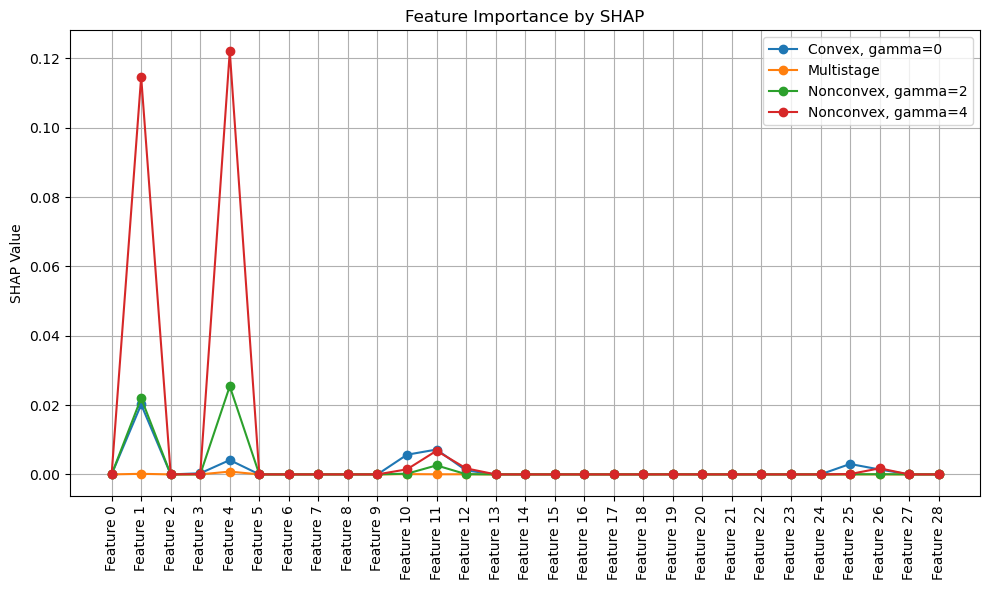

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# === Load and preprocess the SHAP file ===
shap_df = pd.read_csv("cross_validation_shap_2.csv")
shap_df.columns = shap_df.columns.str.strip()

# Convert SHAP value strings to floats
for col in shap_df.columns[1:]:
    shap_df[col] = shap_df[col].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)

# === Step 1: Define original and custom legend names ===
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]

# Editable mapping for custom legend names
legend_labels = {
    "Convex Only": "Convex, gamma=0",
    "Multistage_1": "Multistage",
    "Nonconvex Only": "Nonconvex, gamma=2",
    "Hybrid": "Nonconvex, gamma=4"
}

# === Step 2: Plot each schedule with a custom label ===
plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in shap_df.columns:
        plt.plot(shap_df["Schedule"], shap_df[schedule], marker='o', label=legend_labels.get(schedule, schedule))
    else:
        print(f"Warning: Schedule '{schedule}' not found.")

plt.xticks(rotation=90)
plt.ylabel("SHAP Value")
plt.title("Feature Importance by SHAP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("shap_plot_custom_legend.png")
plt.show()
